In [1]:
___Author___='LumberJack Jyss'

In [2]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


currencies = ['EURJPY=X', 'GBPJPY=X', 'USDJPY=X','GBPUSD=X','BTCUSD=X','ETHUSD=X','GBPEUR=X',\
             'GBPSGD=X','GBPSEK=X','GBPSAR=X','CADUSD=X','CADJPY=X','AUDUSD=X','NZDUSD=X',\
             'NZDGBP=X','NZDEUR=X','AUDGBP=X','AUDEUR=X',]
daily_currency_prices = YahooFinancials(currencies).get_historical_price_data(start,end,'daily')
temp_df = pd.DataFrame.from_dict(daily_currency_prices.values()).T

In [3]:
print('Importation des librairies...')
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from yahoofinancials import YahooFinancials
from sklearn.metrics import mean_squared_error
from math import sqrt
print('Librairies importées')

Importation des librairies...


Using TensorFlow backend.


Librairies importées


In [4]:
start = '2014-01-28'
end = '2019-05-24'

In [5]:
currencies = ['GBPUSD=X']
daily_currency_prices = YahooFinancials(currencies).get_historical_price_data(start,end,'daily')

In [6]:
temp_df = pd.DataFrame.from_dict(daily_currency_prices.values()).T

In [7]:
gbpusd = pd.DataFrame.from_dict(temp_df.iloc[4,0])

In [8]:
df = pd.DataFrame()
df['Date'] = gbpusd['formatted_date']
df['High'] = gbpusd['high']
df['Low'] = gbpusd['low']
df['Open'] = gbpusd['open']
df['Close'] = gbpusd['close']
#df['Volume'] = gbpusd['volume']
df['Adj Close'] = gbpusd['adjclose']

In [9]:
delta = round(df.shape[0])
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("Période d'étude : ",delta)
print('Sur un découpage 80% - 20% de la période : ')
print('Bloc 1 : ',bloc1,' jours \nBloc 2 :',bloc2,' jours')

Période d'étude :  1389
Sur un découpage 80% - 20% de la période : 
Bloc 1 :  1111  jours 
Bloc 2 : 278  jours


In [10]:
df.head()

,Date,High,Low,Open,Close,Adj Close
0,2014-01-28,1.662124,1.654287,1.657523,1.657495,1.657495
1,2014-01-29,1.660550,1.652892,1.656891,1.657001,1.657001
2,2014-01-30,1.656589,1.644899,1.655821,1.655903,1.655903
3,2014-01-31,1.649947,1.643169,1.649430,1.649838,1.649838
4,2014-02-03,1.643791,1.632706,1.643791,1.643791,1.643791


In [11]:
df.tail()

,Date,High,Low,Open,Close,Adj Close
1384,2019-05-19,1.275754,1.271682,1.273026,1.273156,1.273156
1385,2019-05-20,1.279427,1.268617,1.272783,1.272912,1.272912
1386,2019-05-21,NaN,NaN,NaN,NaN,NaN
1387,2019-05-22,1.268343,1.260589,1.266336,1.266416,1.266416
1388,2019-05-24,1.270567,1.265566,1.266255,1.268665,1.268665


In [12]:
df.shape

(1389, 6)

In [13]:
dataset = df.copy()
dataset = dataset.drop(dataset[['Close','Date']],axis=1)
dataset.rename(columns={'Adj Close':'Close'}, inplace=True)
dataset.fillna(dataset.mean(), inplace=True)

In [14]:
dataset.isnull().sum(),type(dataset)

(High     0
 Low      0
 Open     0
 Close    0
 dtype: int64, pandas.core.frame.DataFrame)

In [15]:
dataset.describe()

,High,Low,Open,Close
count,1389.000000,1389.000000,1389.000000,1389.000000
mean,1.423744,1.413996,1.419030,1.419057
std,0.142088,0.142614,0.142383,0.142377
min,1.208751,1.199515,1.203746,1.203935
25%,1.304019,1.295505,1.300559,1.300559
50%,1.391595,1.380662,1.386501,1.386194
75%,1.543496,1.532896,1.536807,1.536665
max,1.718715,1.714237,1.716237,1.716090


In [16]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

In [17]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [18]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [19]:
# transform series into train and test sets for supervised learning
def prepare_data(seriesX, seriesy, n_test, n_lag, n_seq):
	
    # extract raw values
    raw_valuesX,raw_valuesy = seriesX.values,seriesy.values

    # transform data to be stationary
    diff_seriesX = difference(raw_valuesX, 1)
    diff_valuesX = diff_seriesX.values
    diff_valuesX = diff_valuesX.reshape(len(diff_valuesX), 1)
    
    diff_seriesy = difference(raw_valuesy, 1)
    diff_valuesy = diff_seriesy.values
    diff_valuesy = diff_valuesy.reshape(len(diff_valuesy), 1)
    
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_valuesX = scaler.fit_transform(diff_valuesX)
    scaled_valuesX = scaled_valuesX.reshape(len(scaled_valuesX), 1)
    scaled_valuesy = scaler.fit_transform(diff_valuesy)
    scaled_valuesy = scaled_valuesy.reshape(len(scaled_valuesy), 1)

    #transform into supervised learning problem X, y
    supervisedX = series_to_supervised(scaled_valuesX, n_lag, n_seq)
    supervised_valuesX = supervisedX.values

    # split into train and test sets
    train, test = supervised_valuesX[0:-n_test], supervised_valuesX[-n_test:]
    return scaler, train, test

In [39]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True,return_sequences = True))
    model.add(LSTM(units = 20, return_sequences = True))
    model.add(Dropout(0.3))
    model.add(LSTM(units = 10))
    model.add(Dropout(0.4))  
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
    for i in range(nb_epoch):
        print('Super Epoch Nb',i,'/',nb_epoch)
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [31]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

In [32]:
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

In [33]:
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

In [34]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = np.array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

In [35]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

In [36]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(seriesX, forecasts, n_test):
    # plot the entire dataset in blue
    plt.figure(figsize=(16,6),dpi=200)
    plt.xlim(1370,1385 )
    plt.ylim(1.25,1.35)
    plt.suptitle('Prediction of GBPUSD with DEEP LEARNING',fontsize=16)
    plt.plot(seriesX.values,color='purple',label='Actual',)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(seriesX) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [seriesX.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='orange',label='Trend Predictions')
    # show the plot
    plt.legend()
    plt.show()

In [40]:
# load dataset
seriesX = dataset.iloc[:,2]
seriesy = dataset.iloc[:,3]

# configure
n_lag = 1
n_seq = 3
n_test = 10
n_epochs = 10
n_batch = 1
n_neurons = 1

# prepare data
scaler, train, test = prepare_data(seriesX, seriesy, n_test, n_lag, n_seq)

In [41]:
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

Super Epoch Nb 0 / 10
Epoch 1/1
1375/1375 [==============================] - 7s 5ms/step - loss: 0.0047
Super Epoch Nb 1 / 10
Epoch 1/1
1375/1375 [==============================] - 5s 4ms/step - loss: 0.0047
Super Epoch Nb 2 / 10
Epoch 1/1
1375/1375 [==============================] - 5s 4ms/step - loss: 0.0047
Super Epoch Nb 3 / 10
Epoch 1/1
1375/1375 [==============================] - 5s 4ms/step - loss: 0.0047
Super Epoch Nb 4 / 10
Epoch 1/1
1375/1375 [==============================] - 5s 4ms/step - loss: 0.0047
Super Epoch Nb 5 / 10
Epoch 1/1
1375/1375 [==============================] - 6s 4ms/step - loss: 0.0047
Super Epoch Nb 6 / 10
Epoch 1/1
1375/1375 [==============================] - 6s 4ms/step - loss: 0.0047
Super Epoch Nb 7 / 10
Epoch 1/1
1375/1375 [==============================] - 6s 4ms/step - loss: 0.0047
Super Epoch Nb 8 / 10
Epoch 1/1
1375/1375 [==============================] - 7s 5ms/step - loss: 0.0047
Super Epoch Nb 9 / 10
Epoch 1/1
1375/1375 [=====================

In [42]:
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

In [43]:
# inverse transform forecasts and test
forecasts = inverse_transform(seriesX, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(seriesX, actual, scaler, n_test+2)

In [44]:
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

t+1 RMSE: 0.046491
t+2 RMSE: 0.046880
t+3 RMSE: 0.045433


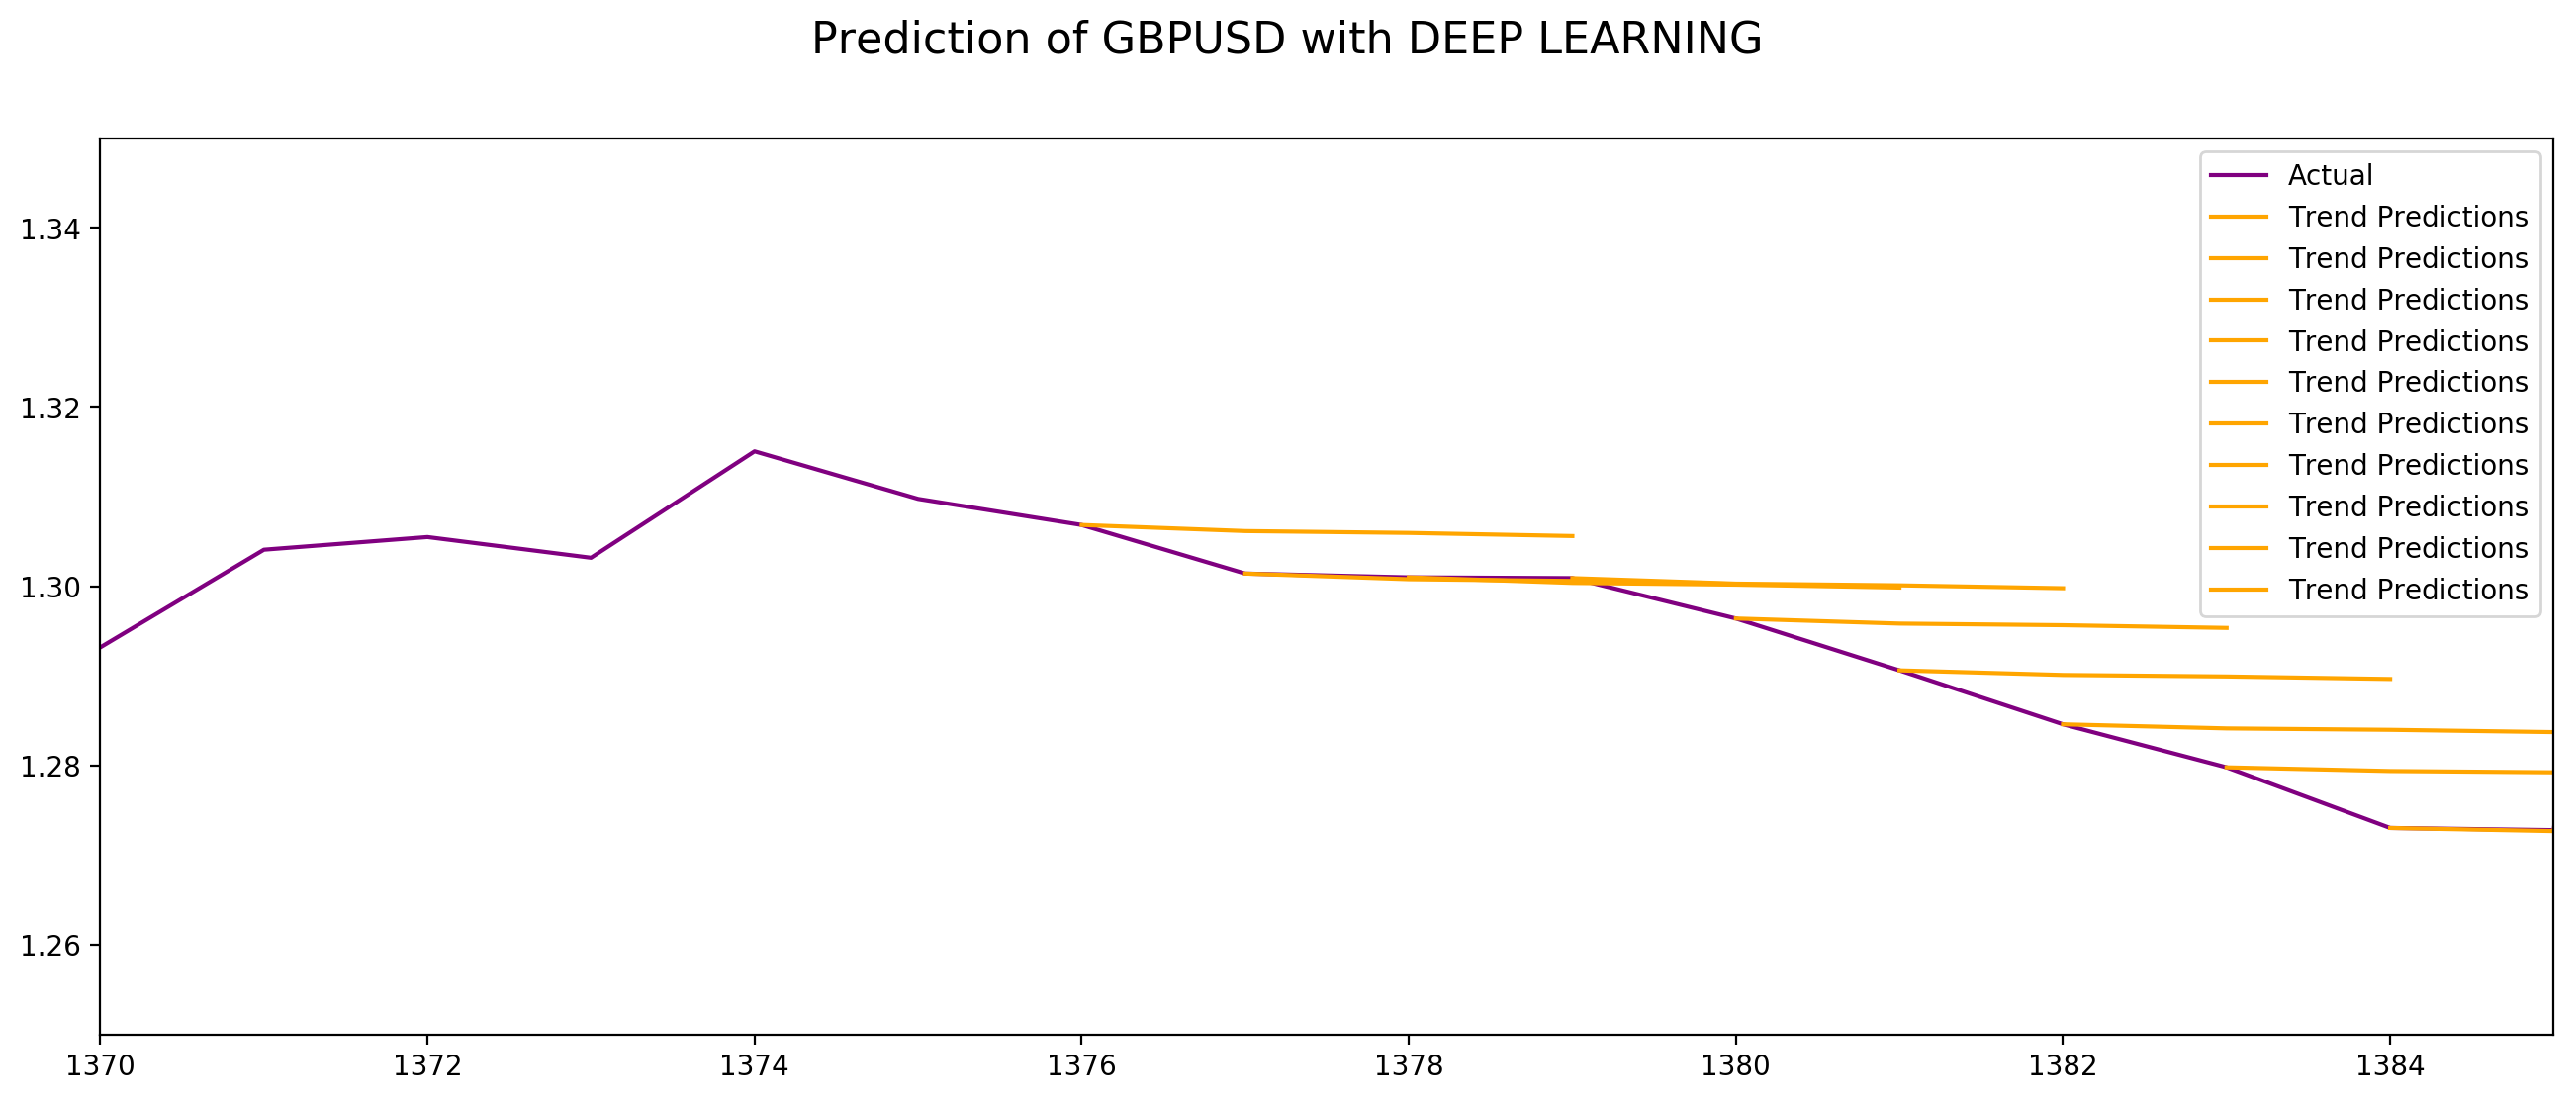

In [45]:
# plot forecasts
plot_forecasts(seriesX, forecasts, n_test+2)